# 1) Sujet

## 1.1) Contexte
Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin. 

Ce marché américain étant particulièrement liquide, l’enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d’investissement ou d’arbitrage.

## 1.2) Description des données
- **Index des données**  
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).  
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.  

- **Variables explicatives** :  
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d’autres features dérivées.

- **Variable cible** :  
  - `reod` {-1, 0, 1\} indiquant la tendance de l’actif entre 14h et 16h (baisse, stable ou hausse).

## 1.3) Description du benchmark
Le benchmark mentionné propose un re de référence autour de 33% (basé sur des prédictions aléatoires) et un modèle plus élaboré atteint environ 41,74%. Notre objectif est de dépasser ce score en construisant un pipeline de Machine Learning robuste et optimisé.

---




# 2) Problématique
Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :
- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).  
- La **présence de valeurs manquantes** (`NaN`).  
- L’**absence de jours/actions communs** entre le jeu d’entraînement et le jeu de test, ce qui complique l’utilisation directe de `equity` ou `day` en tant que features.  
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.

---



# 3) Préparation des données

## 3.1) Importations des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## 3.2) Importation des données

In [ ]:
X = pd.read_csv(r'input_training.csv')
X.sort_values(by="ID",inplace=True)

y = pd.read_csv(r'output\output_training_gmEd6Zt.csv')

input_test = pd.read_csv(r'input_test.csv')
input_test.sort_values(by="ID",inplace=True)


output_random_bench = pd.read_csv(r"output\output_test_random.csv")

## 3.3) Exploration des données

1. **Analyse des valeurs manquantes** : taux de NaN par colonne, par ligne, distribution des NaN.
2. **Statistiques descriptives** (moyenne, écart-type, quantiles) sur les rendements.  
---


<Axes: >

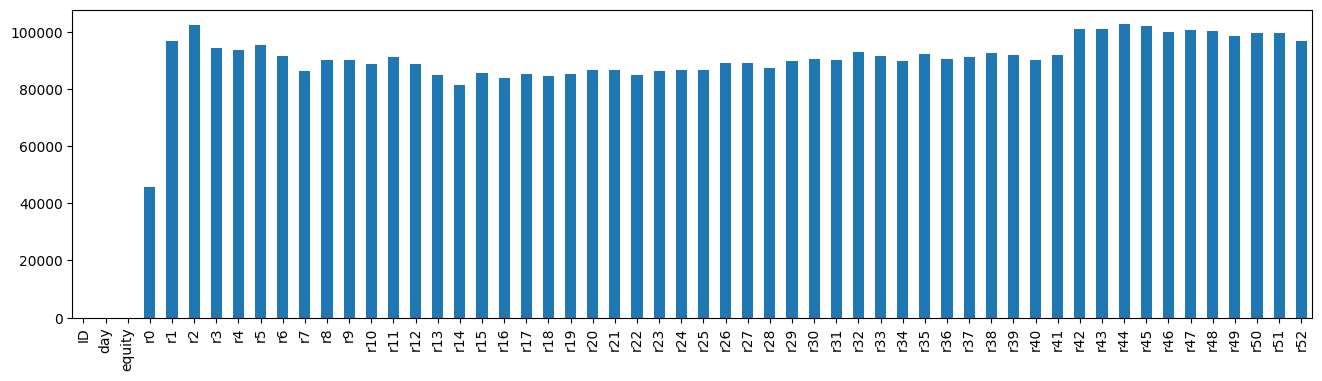

In [3]:
plt.figure(figsize=(16,4))
(X.isna().sum()).plot.bar()

In [4]:
col_rendements = [col for col in X.columns if col.startswith("r")]

NaN_analysis = pd.DataFrame()
NaN_analysis["NaN_count"] = X[col_rendements].isna().sum(axis=1)

nombre_colonnes = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"]/nombre_colonnes)*100

nbr_row_na = X.isna().any(axis=1).sum()

print(f"Nombre de ligne totale du dataset {len(X)}")
print(f"nombre de lignes contenant au moins des NaN {nbr_row_na}, soit en %: {(nbr_row_na/len(X)*100)}")
print(f"nombre de lignes avec plus 30% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>30])/len(X)*100}")
print(f"nombre de lignes avec plus 50% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])/len(X)*100}")

Nombre de ligne totale du dataset 843299
nombre de lignes contenant au moins des NaN 242363, soit en %: 28.739865694136956
nombre de lignes avec plus 30% de NaN dans une colonne 80786, soit en % 14.89898600614966
nombre de lignes avec plus 50% de NaN dans une colonne 80786, soit en % 9.579757594874415


In [5]:
print(f"nombre de lignes data input train {len(X)}")
print(f"Nombre de lignes output_training {len(y)}")
print(f"Nombre de lignes data input test {len(input_test)}")
print(f"Nombre de lignes de l'output random bench {len(output_random_bench)}")

nombre de lignes data input train 843299
Nombre de lignes output_training 843299
Nombre de lignes data input test 885799
Nombre de lignes de l'output random bench 885799


In [12]:
X_train = pd.merge(X,y,on="ID")
X_train

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r44,r45,r46,r47,r48,r49,r50,r51,r52,reod
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00,0
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68,0
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96,-1
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843294,843294,297,123,3.96,0.00,-70.34,74.24,-0.56,0.00,-23.63,...,1.71,0.00,-3.98,2.28,-21.62,-1.71,9.12,0.00,9.11,1
843295,843295,16,1501,0.00,-183.49,-13.19,46.24,0.00,-39.60,13.25,...,6.62,0.00,19.85,0.00,-26.42,6.62,0.00,0.00,-19.88,-1
843296,843296,166,1231,37.02,2.93,-3.67,16.89,-4.03,13.56,-4.39,...,-3.28,-1.46,-3.65,-1.10,-13.51,2.92,-6.21,9.69,-3.66,0
843297,843297,297,747,34.45,15.10,-35.61,19.25,-16.46,-26.12,20.68,...,-5.52,-6.90,9.67,1.38,6.90,-11.04,33.16,13.77,12.38,1


# 4) Benchmark (modèle simple)

## 4.1) Expérience avec Random Forest
- Nous avons d’abord tenté un **RandomForestClassifier** (pipeline basique + imputation).  
- Sur de grands volumes de données, nous avons rencontré des **erreurs de mémoire** (MemoryError) après plusieurs heures d’entraînement, montrant que cette approche n’était pas adaptée dans notre configuration (en particulier si `n_estimators` et `max_depth` sont trop élevés). (Ca a tourné 5H avant de gentiment me dire d'aller voir ailleurs)


In [ ]:
X_rendements = pd.DataFrame(X.loc[:,"r0":"r52"].fillna(0))

X_train, X_val, y_train, y_val = train_test_split(X_rendements,y,test_size=0.1, random_state=42)

#On crée un pipeline :
pipeline_bench = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=10,max_depth=10,random_state=42, n_jobs=1)),
]) # Avant essai avec 50 estimators

pipeline_bench.fit(X_train,y_train)

y_pred = pipeline_bench.predict(X_val)

print("Accuracy", accuracy_score(y_val,y_pred))
print("Matrice de confusion : \n", confusion_matrix(y_val, y_pred))
print("Rapport de classification: \n", classification_report(y_val,y_pred))




## 5.2) Pourquoi s’orienter vers XGBoost ?
- **XGBoost** (ou LightGBM) est un algorithme de **gradient boosting** très optimisé pour les données tabulaires volumineuses.  
- Il gère mieux la mémoire, propose des méthodes de recherche de split plus efficaces et peut gérer des valeurs manquantes.  
- Expérience terrain et compétitions : XGBoost est souvent **plus rapide** et **plus performant** qu’une Random Forest sur de gros datasets.


In [7]:
from xgboost import XGBClassifier

In [13]:
X_rendements = pd.DataFrame(X.loc[:,"r0":"r52"].fillna(0))
y_rendements = X_train["reod"]

X_train, X_val, y_train, y_val = train_test_split(X_rendements,y_rendements,test_size=0.2, random_state=42)


model = XGBClassifier(
    objective='multi:softmax',  # pour classification multi-classes
    num_class=3,               # si vous avez 3 classes : -1, 0, +1
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])
#On crée un pipeline :
pipeline_bench = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=10,max_depth=10,random_state=42, n_jobs=-1)),
]) 

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy :", accuracy)

print("\nClassification Report :")
print(classification_report(y_test, y_pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]

## Ce que nous comptons faire

Nous allons explorer plusieurs approches afin d'optimiser notre pipeline de prédiction. Voici notre plan d'expérimentation et d'optimisation :

1. **Création de plusieurs jeux de données :**  
   - **Dataset complet :** Conserver toutes les observations, même celles contenant des valeurs manquantes (NA).  
   - **Dataset filtré :** Retirer les lignes où plus de 30% des colonnes présentent des NA.
   - **Stratégies d'imputation :** Tester différentes méthodes pour compléter les valeurs manquantes, telles que :
     - Interpolation linéaire.
     - Imputation par KNN.
     - Imputation par stratégie simple (moyenne, médiane, etc.).

2. **Feature Engineering et Encodage :**  
   - **Extraction de statistiques à partir des rendements :** Calculer, par exemple, la moyenne, l'écart-type, la somme cumulée, etc.
   - **Exploitation des variables catégorielles `equity` et `day` :**  
     - Pour `equity` : Extraire des agrégats (moyenne historique, volatilité, etc.) pour construire un "profil" de l'action.
     - Pour `day` : Extraire des caractéristiques globales (tendance générale du marché, effet de la veille, etc.) qui pourraient influencer la performance du jour. (calculer le nombre moyen de mouvement haussier pour un jour, mouvement baissier, neutre...) --> Permettrait de mettre en avant un effet bullish ou bearish. 
   - Comparer l’impact de ces transformations sur les performances du modèle.
   Concernant l'encodage : nous n'avons pas encore trouvé de manière d'encoder les variables equity et day en tant que tel à part en calculant des statistiques / caractéristiques globales

3. **Essais avec des modèles simples :**  
   - Développer des modèles de base (XGBoost) sur chacun des jeux de données préparés.
   - Évaluer les performances à l’aide de métriques telles que l’accuracy et la matrice de confusion.
   - Vérifier l’impact des différentes stratégies d’imputation sur les résultats.

4. **Passage à des modèles plus complexes :**  
   - Utiilisation de réseaux de neurones : LSTM ou un simple MLP.

5. **Optimisation des hyperparamètres :**  
   - Utiliser la validation croisée (k-fold) pour obtenir une estimation robuste de la performance.
   - Mettre en place une recherche d’hyperparamètres (avec GridSearchCV ou RandomizedSearchCV) pour optimiser :
     - Le taux d’apprentissage (`learning_rate`).
     - Le nombre d’arbres (`n_estimators`).
     - La profondeur maximale (`max_depth`).
     - Les taux de subsampling, etc.
